# Identifying Distinctive Terms in a Workset Using TF*IDF
*Isaac Wink and Brice Bowrey*


In [1]:
# Library imports
import requests
import json
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Adjust this workset ID to generate widget results for different worksets:
SAMPLE_WORKSET_ID = "640ba4bf300000440a5ce31a"

# Accessing Data

In [3]:
def read_word_data(filename):
    '''Reads in a file of words, one per line, and returns a pandas Series of the words in lower case'''
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(line.strip().casefold())
    return pd.Series(data)

In [4]:
def post_workset(payload):
  '''Posts a workset to the HTRC Extracted Features API and return the workset ID
  
  Parameters:
  payload (str): the payload to be posted to the API. This should be a blankspace-delimited list of volume IDs

  Returns:
  workset_id (str): the ID of the workset created on HathiTrust servers
  '''
  url = "https://data.htrc.illinois.edu/ef-api/worksets"

  headers = {
      "Content-Type": "text/plain",
      "Accept": "application/json"
  }

  response = requests.post(url, data=payload, headers=headers)
  response_json = response.json()

  workset_id = response_json['data']['id']

  return workset_id

In [5]:
def get_workset(workset_id, save_data=False):
  '''Uses the HTRC Extracted Features API to retrieve volume data for a workset ID
  
  Parameters:
  workset_id (str): the ID of the workset to retrieve
  save_data (bool): whether to save the data to a file
  
  Returns:
  workset_data (dict): the data retrieved from the API
  '''
  api_get_volume = "https://data.htrc.illinois.edu/ef-api/worksets/{}/volumes/aggregated".format(workset_id)
  response = requests.get(api_get_volume)

  # Check if the request was successful
  workset_data = response.json()

  if save_data:
    with open(file=volume_id, mode='w') as f:
      json.dump(workset_data, f)

  if workset_data["code"] == 200:
    print("Successfully retrieved data from API")
    return workset_data
  else:
    print(f'Failed to retrieve data: {workset_data["code"]}')
    return None

In [6]:
def get_workset_volumes_aggregated(workset_data):
  '''Extracts the volume IDs and feature data from the workset data
  
  Parameters:
  workset_data (dict): the data retrieved from the API
  
  Returns:
  workset_volumes_aggregated (dict): a dictionary of volume IDs and their feature data in the format {volume_id:{word:count}}
  '''
  workset_total_wc = {} # {volume_id:{word:count}}
  for volume in workset_data['data']:
    volume_id = volume['htid']
    workset_total_wc['{}'.format(volume_id)] = volume['features']['body']

  return workset_total_wc

In [7]:
workset_data = get_workset(SAMPLE_WORKSET_ID)
workset_wc = get_workset_volumes_aggregated(workset_data)

Successfully retrieved data from API


In [8]:
# Create a dataframe from the dictionary, making all words lowercase and removing non-alphanumeric words:
wc_dict = {}
for volume in workset_wc.keys():
  wc_dict[volume] = {}
  for term in workset_wc[volume].keys():
    lower_term = term.lower()
    # if not lower_term.isalpha():
    #   continue
    if lower_term in wc_dict[volume].keys():
      wc_dict[volume][lower_term] += workset_wc[volume][term]
    else:
      wc_dict[volume][lower_term] = workset_wc[volume][term]

# Convert dict to list for adding to dataframe:
volume_id_list = []
term_list = []
count_list = []
for volume in wc_dict.keys():
  for term in wc_dict[volume].keys():
    volume_id_list.append(volume)
    term_list.append(term)
    count_list.append(wc_dict[volume][term])

# Create the dataframe containing term frequencies separated by volume:
corpus_df = pd.DataFrame({'term': term_list, 'volume_id': volume_id_list, 'count': count_list})

Cleaning the data against a dictionary of English words eliminates ocr errors, but also excludes some proper nouns (Oreos, Bojangles, Sergeyevich), colloquialism (teetotallers, gimmie, coulda), old english (stealeth), words where putting (or not putting) a hyphen/space is debated or uncommon (spellingbook, yellowfever, british-made), and corpus words that didn't get lemmatized so they don't match the singular form in the wordlist (afro-americans).

I found the list at: https://github.com/dwyl/english-words/tree/master

-Brice

In [9]:
corpus_df.shape

(173989, 3)

In [10]:
# Clean data against a list of english words
word_list = read_word_data('words.txt')

# To see excluded words
excluded_df = corpus_df[~corpus_df['term'].isin(word_list)]
excluded_df.to_csv('excluded_words.csv')

corpus_df = corpus_df[corpus_df['term'].isin(word_list)]

In [11]:
corpus_df.shape

(160332, 3)

# TF*IDF Calculations

In [12]:
# Produce a string of all text in each volume and store in list of strings workset_wc_concat
corpus_df['strings'] = (corpus_df['term'] + ' ')*corpus_df['count']

workset_wc_concat = []
for volume in corpus_df['volume_id'].unique():
    workset_wc_concat.append(' '.join(corpus_df[corpus_df['volume_id'] == volume]['strings']))

In [13]:
# Documentation for vectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

def create_vectorizer(max_df=0.95, min_df=.02, sublinear_tf=True):
    '''Creates a TfidfVectorizer object with the desired parameters'''
    return TfidfVectorizer(max_df=max_df,  # max document frequency. Words in more the x% of volumes will be ignored
                             min_df=min_df, # min document frequency. Words in less the x% of volumes will be ignored
                             sublinear_tf=sublinear_tf, # use logarithmic scale for term frequency.
                             )

In [14]:
# Vectorize and isolate keywords from documents
vectorizer = create_vectorizer()

vectors = vectorizer.fit_transform(workset_wc_concat)
feature_names = vectorizer.get_feature_names_out()

dense = vectors.todense()
denselist = dense.tolist()

In [15]:
# Validation
print(len(denselist)) # This should be the same as the number of volumes in the workset
print(corpus_df['volume_id'].unique()[0]) # This should be a volume_id in the workset

25
mdp.39015000544745


In [16]:
# See top tf-idf scores for a given volume
pd.DataFrame({"term": feature_names, "tf-idf":denselist[3]}).sort_values(by='tf-idf', ascending=False).head(10).reset_index(drop=True)

,term,tf-idf
0,louella,0.081378
1,arthur,0.077956
2,kevin,0.075288
3,buggy,0.071186
4,trumbull,0.070613
5,mona,0.068864
6,nadine,0.068594
7,ricky,0.065484
8,bertha,0.064934
9,helen,0.064408


# Potential Widget Functions

## Option 1: Develop a comparison chart of the 10 most distinctive terms in each volume

In [17]:
comparison_dict = {"Volume" : [], "Most Distinctive Terms" : []}
for i in range(len(corpus_df['volume_id'].unique())):
    # Note that this loop assumes the index of each volume in the workset is the same as its
    # index in denselist list (which should be the case)
    volume_title = workset_data["data"][i]["metadata"]["title"].strip("/. \n")
    comparison_dict["Volume"].append(volume_title)
    top_scores_df = pd.DataFrame({"term": feature_names, "tf-idf":denselist[i]}).sort_values(by='tf-idf', ascending=False).head(10).reset_index(drop=True)
    top_scores_str = ", ".join(top_scores_df["term"])
    comparison_dict["Most Distinctive Terms"].append(top_scores_str)

comparison_df = pd.DataFrame(comparison_dict)
comparison_df

,Volume,Most Distinctive Terms
0,Portrait of a young man drowning,"arnie, hap, abie, ding, dong, georgie, madden,..."
1,Click song,"allis, glenn, cate, cato, amos, alejo, ike, ma..."
2,Moustapha's eclipse,"treadwell, idi, caspar, lenny, louellen, maggi..."
3,"Trumbull park, a novel","louella, arthur, kevin, buggy, trumbull, mona,..."
4,Death on the rocks,"stroheim, steele, skipper, von, perez, leopard..."
5,The music of summer,"armand, milt, cathy, clarice, lottie, gladys, ..."
6,Sisters & lovers,"charmaine, evelyn, beverly, kenny, clarence, k..."
7,Her own place : a novel,"mae, granger, annie, lee, hooker, barnes, jeff..."
8,Autobiography of a family photo : a novel,"marianna, cory, troy, olga, carlos, cecilia, c..."
9,The cattle killing,"stubbs, liam, thrush, kathryn, smellie, carey,..."


## Option 2: Generate a wordcloud of the most distinctive terms in a single volume

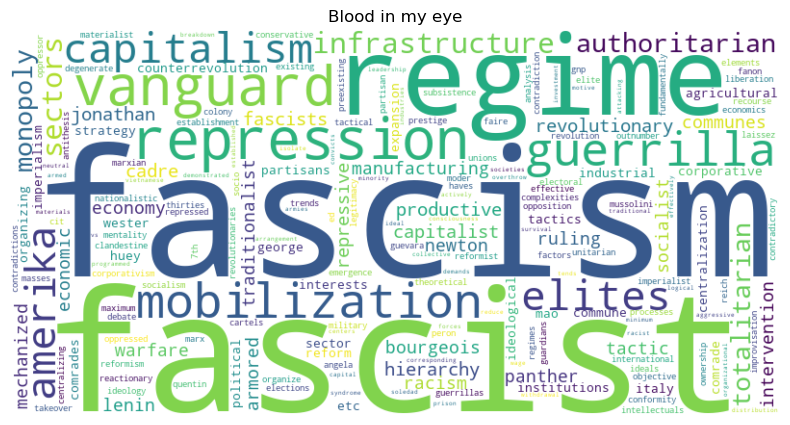

In [19]:
# For now, generate a wordcloud for a random volume in the workset
# Could probably add a selector option somehow on the dashboard
import random
vol_index = random.randint(0, len(corpus_df['volume_id'].unique()) - 1)

# Get the volume tf*idf scores and title:
vol_df = pd.DataFrame({"term": feature_names, "tf-idf":denselist[vol_index]})
vol_title = workset_data["data"][vol_index]["metadata"]["title"].strip("/. \n")

# Convert the DataFrame to a dictionary
word_freq = dict(zip(vol_df["term"], vol_df["tf-idf"]))

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the wordcloud
plt.figure(figsize=(10, 5))
plt.title(vol_title)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Option 3: Download a CSV containing the tf*idf scores by volume for every term in the corpus

In [15]:
def tfidf_csv(titles=True, compressed=False):
    '''Create a CSV from the denselist dataframe. 
       By default, make column headers titles instead of HTIDs
       and do not compress the CSV. Ideally, dashboard users can select
       these choices as radio buttons when downloading the scores'''
    
    dict_from_denselist = {i: item for i, item in enumerate(denselist)}
    tfidf_df = pd.DataFrame.from_dict(dict_from_denselist)
    if titles:
        volume_titles = []
        for i in range(len(corpus_df["volume_id"].unique())):
            volume_titles.append(workset_data["data"][i]["metadata"]["title"])
        tfidf_df.columns = volume_titles
        tfidf_df.index = feature_names
    else:
        tfidf_df.columns = corpus_df['volume_id'].unique()
        tfidf_df.index = feature_names
    if compressed:
        tfidf_df.to_csv("tf-idf.csv.zip", compression='zip')
    else:
        tfidf_df.to_csv("tf-idf.csv")
    print("CSV saved successfully")

In [16]:
tfidf_csv()

CSV saved successfully
